In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.linear_model import Ridge
from pandas import DataFrame
from numpy import *
import copy
import json, io
import sys

In [39]:
dataset = pd.read_csv('../data/data.csv')
df = dataset.copy()
datasetArray = df.values

dataAvailableFrom = 'April-01' # Index: 24
dataAvailableUntil = 'October-05'

bd_data = []
for i in range(24, len(datasetArray)):
    bd_data.append(datasetArray[i])
    if datasetArray[i][0] == dataAvailableUntil: 
        break

total_days = len(bd_data)

Total number of days:  188


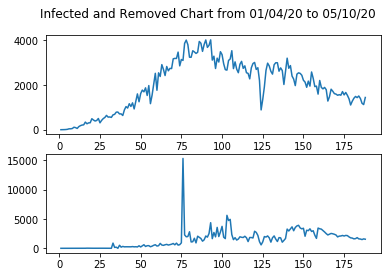

In [40]:
infected = []
removed = []
isolated = []
for i in range(len(bd_data)):
    infected.append(bd_data[i][2])
    removed.append(bd_data[i][3]+bd_data[i][4])
    isolated.append(bd_data[i][5])
    
prev_infected = 0
prev_removed = 0
prev_isolated = 0

for i in range(len(infected)):
    if isnan(infected[i]) or infected[i] == 0:
        infected[i] = prev_infected
    if isnan(removed[i]) or removed[i] == 0:
        removed[i] = prev_removed
    if isnan(isolated[i]) or isolated[i] == 0:
        isolated[i] = prev_isolated
    
    prev_infected = infected[i]
    prev_removed = removed[i]
    prev_isolated = isolated[i]

data_from = '01/04/20'
data_to = '05/10/20'
print('Total number of days: ', total_days)

days = np.arange(1, total_days + 1).tolist()
name, chart = plt.subplots(2)
name.suptitle(f'Infected and Removed Chart from {data_from} to {data_to}')
chart[0].plot(days, infected)
chart[1].plot(days, removed)

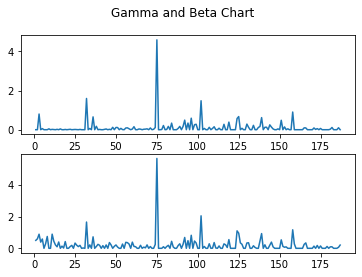

In [41]:
POPULATION = 161400000

def calc_gamma(r0, r1, i0, non_i0):
    if i0 + non_i0 != 0:
        return (r1 - r0) / (i0 + non_i0)
    else:
        return 0

def calc_beta(i0, i1, non_i0, non_i1, r0, r1, st):
    fact = (st * non_i1 / POPULATION)
    if fact != 0:
        return (i1 - i0 + non_i1 - non_i0 + r1 - r0) / fact
    else:
        return 0

sus = [POPULATION]
beta_t = []
gamma_t = []
ft_t = [0] * total_days;

for i in range(len(bd_data)):
    if infected[i] != 0 : 
        ft_t[i] = isolated[i] / infected[i]

for i in range(len(bd_data) - 1):
    r0 = removed[i]
    r1 = removed[i+1]
    i0 = isolated[i]
    i1 = isolated[i+1]
    non_i0 = infected[i]-isolated[i]
    non_i1 = infected[i+1]-isolated[i+1]
    st = sus[i]
    
    GAMMA = calc_gamma(r0, r1, i0, non_i0)
    BETA = calc_beta(i0, i1, non_i0, non_i1, r0, r1, st)
    
    if GAMMA < 0: GAMMA = 0
    if BETA < 0: BETA = 0
    
    sus.append(st - (BETA * st * non_i0 / POPULATION))
    
    gamma_t.append(GAMMA)
    beta_t.append(BETA)

# print(sus)
# print(beta_t)
# print(gamma_t)
# print(ft_t)

days = np.arange(1, total_days).tolist()
name, chart = plt.subplots(2)
name.suptitle('Gamma and Beta Chart')
chart[0].plot(days, gamma_t)
chart[1].plot(days, beta_t)

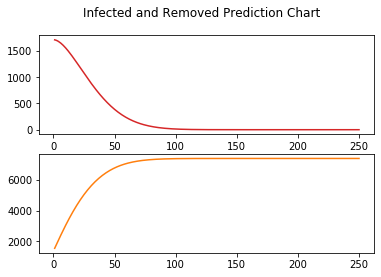

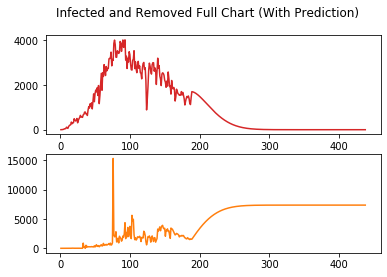

In [42]:
def convert(arr):
    res = []
    for i in range(len(arr)):
        res.append([arr[i]])
    return res

days = convert(np.arange(1, total_days).tolist())
ft_days = convert(np.arange(1, total_days + 1).tolist())

beta_model = Ridge().fit(days, convert(beta_t))
gamma_model = Ridge().fit(days, convert(gamma_t))
ft_model = Ridge().fit(ft_days, convert(ft_t))


days_test = []
test_days = 250
for day in range(total_days + 1, total_days + test_days + 1):
    days_test.append(np.array([[day]]))

prob_beta = [beta_t[len(beta_t)-1]]
prob_gamma = [gamma_t[len(gamma_t)-1]]
prob_ft = [ft_t[len(ft_t)-1]]

for i in range(test_days):
    prob_beta.append(beta_model.predict(days_test[i])[0][0])
    prob_gamma.append(gamma_model.predict(days_test[i])[0][0])
    prob_ft.append(ft_model.predict(days_test[i])[0][0])

# days = np.arange(1, test_days + 2).tolist()
# name, chart = plt.subplots(3)
# name.suptitle('Infected and Removed Prediction Chart')
# chart[0].plot(days, prob_beta, 'tab:red')
# chart[1].plot(days, prob_gamma, 'tab:orange')
# chart[2].plot(days, prob_ft, 'tab:green')

# print(len(days), len(prob_beta), len(prob_gamma), len(prob_ft))

def super_prediction(prob_beta, prob_gamma, prob_ft):
    last_iso = isolated[(len(isolated) - 1)] 
    last_un_iso = infected[len(infected) - 1] - last_iso
    last_removed = removed[len(removed) - 1]
    last_sus = sus[len(sus) - 1]

    new_iso_count = []
    new_uniso_count = []
    new_removed_count = []
    new_sus_count = []
    
    for i in range(test_days):
        cur_sus = last_sus - (prob_beta[i] * last_sus * last_un_iso / POPULATION)
        cur_iso = last_iso + (prob_ft[i]*prob_beta[i]*last_un_iso * last_sus / POPULATION) - (prob_gamma[i]*last_iso) 
        cur_un_iso = ((1 - prob_ft[i])*prob_beta[i] * last_un_iso * last_sus / POPULATION) - (prob_gamma[i] * last_un_iso) + last_un_iso
        cur_rem = (prob_gamma[i]*(last_iso+last_un_iso)) + last_removed
        
        new_iso_count.append(cur_iso)
        new_uniso_count.append(cur_un_iso)
        new_removed_count.append(cur_rem)
        new_sus_count.append(cur_sus)
        
        last_iso = copy.deepcopy(cur_iso)
        last_un_iso = copy.deepcopy(cur_un_iso)
        last_removed = copy.deepcopy(cur_rem)
        last_sus = copy.deepcopy(cur_sus)
        
    return [new_iso_count, new_uniso_count, new_removed_count, new_sus_count]

pred_iso, pred_uniso, pred_removed, pred_sus = super_prediction(prob_beta, prob_gamma, prob_ft)

def get_infected(iso, uniso):
    infected = []
    for i in range(len(iso)): 
        infected.append(iso[i] + uniso[i])
    return infected

pred_infected = get_infected(pred_iso, pred_uniso)

def modifyArray(arr):
    for i in range(len(arr)): 
        if arr[i] < 0: arr[i] = 0


modifyArray(pred_infected)
# # modifyArray(pred_removed)

days = np.arange(1, test_days + 1).tolist()
name, chart = plt.subplots(2)
name.suptitle('Infected and Removed Prediction Chart')
chart[0].plot(days, pred_infected, 'tab:red')
chart[1].plot(days, pred_removed, 'tab:orange')
# print(len(days), len(pred_infected), len(pred_removed))

# print(f'Next {test_days} Days Infected:')
# print(pred_infected)
# print('\n\n\n')
# print(f'Next {test_days} Days Removed:')
# print(pred_removed)

# print(f'{ft_prob * 100}% infected people are in isolation!')

# flag = False
# for i in range(len(pred_infected)): 
#     if pred_infected[i] <= 0: 
#         print(f'There will be no infected person after {i + 1} days if {ft_prob * 100}% infected are kept in isolation.')
#         flag = True
#         break
# if(flag == False): print(f'It takes more than {test_days} days to see no infected person!')

# flag = False
# for i in range(len(pred_infected)): 
#     if pred_removed[i] <= 0: 
#         print(f'Everyone will be recovered from COVID-19 after {i + 1} days if {ft_prob * 100}% infected are kept in isolation.')
#         flag = True
#         break
# if(flag == False): print(f'It takes more than {test_days} days to see everyone recovered!')


# # Complete Chart
days = np.arange(1,  test_days + 1 + len(infected)).tolist()
name, chart = plt.subplots(2)
name.suptitle('Infected and Removed Full Chart (With Prediction)')
chart[0].plot(days, infected + pred_infected, 'tab:red')
chart[1].plot(days, removed + pred_removed, 'tab:orange')